<a href="https://colab.research.google.com/github/atanasiusps/Machine-Learning/blob/main/UAS/UAS_RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tahap 1 : Memuat dan Menampilkan Dataset


In [ ]:
import pandas as pd
import numpy as np

# Load data dari file CSV tanpa header
df = pd.read_csv('RegresiUTSTelkom.csv', header=None)

# Buang baris yang mengandung NaN (jika ada)
df = df.dropna()

# Salin agar tidak muncul SettingWithCopyWarning
df = df.copy()

# Ubah nama kolom pertama menjadi 'year' (sebagai target)
df.rename(columns={0: 'year'}, inplace=True)

# Pisahkan fitur dan target
X = df.drop(columns='year')
y = df['year']

# Tampilkan dimensi dan beberapa data awal
print("Jumlah sampel:", len(df))
print("Jumlah fitur:", X.shape[1])
print("Contoh fitur:\n", X.head())
print("Contoh target:\n", y.head())


Jumlah sampel: 515345
Jumlah fitur: 90
Contoh fitur:
          1         2         3         4         5         6         7   \
0  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         8         9        10  ...        81         82        83        84  \
0 -12.23257   7.83089 -2.46783  ...  13.01620  -54.40548  58.99367  15.37344   
1  -0.92019  18.76548  4.59210  ...   5.66812  -19.68073  33.04964  42.87836   
2  -2.35035  16.07017  1.39518  ...   3.03800   26.05866 -50.92779  10.93792   
3 -10.34124   3.55005 -6.36304  ...  34.57337 -171.70734 -16.96705 -46.67617   
4  -9.37636  12.63699  0.93609  ...   9.92661  -55.95724  64.92712 -17.72522   

         85   

### Tahap 2 : Normalisasi dan Pemisahan Data

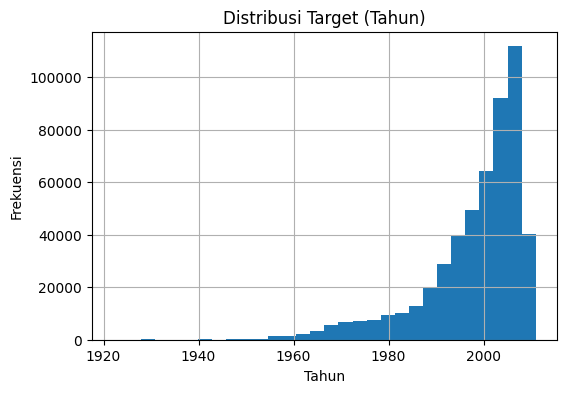

X_train shape: (412276, 90)
X_test shape: (103069, 90)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# (Opsional) Cek distribusi target
plt.figure(figsize=(6,4))
y.hist(bins=30)
plt.title("Distribusi Target (Tahun)")
plt.xlabel("Tahun")
plt.ylabel("Frekuensi")
plt.show()

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

### Tahap 3a : Membangun Arsitektur MLP menggunakan Keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Arsitektur MLP
def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1)  # output regresi
    ])
    return model

# Buat model
model = build_model(X_train.shape[1])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,737 (81.00 KB)

 Trainable params: 20,353 (79.50 KB)

 Non-trainable params: 384 (1.50 KB)

### Tahap 3b : Kompilasi Model (AdamW, Learning Rate Scheduler, Early Stopping)

In [ ]:
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

# Scheduler: Cosine annealing with warm restarts
initial_lr = 1e-3
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.8,
    alpha=1e-5
)

# Optimizer AdamW
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

# Kompilasi model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Callback: Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


### Tahap 3c : PyTorch End-to-End Regressor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# ===== 1. Split data dan normalisasi =====
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)

# ===== 2. Arsitektur MLP dengan teknik deep learning =====
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.3)

        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        return self.out(x)

model = MLPRegressor(input_dim=X.shape[1])

# ===== 3. Optimizer, Loss, Scheduler =====
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ===== 4. Training loop dengan early stopping =====
best_val_loss = np.inf
patience = 10
counter = 0

for epoch in range(100):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    avg_val = np.mean(val_losses)
    scheduler.step(avg_val)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pt'))


Epoch 01 | Train Loss: 3821241.8912 | Val Loss: 3505359.7637
Epoch 02 | Train Loss: 2973644.6137 | Val Loss: 2409126.3489
Epoch 03 | Train Loss: 1819462.0878 | Val Loss: 1271256.2225
Epoch 04 | Train Loss: 847523.2182 | Val Loss: 474259.4619
Epoch 05 | Train Loss: 283680.6198 | Val Loss: 114556.9488
Epoch 06 | Train Loss: 80260.6203 | Val Loss: 20275.9372
Epoch 07 | Train Loss: 41205.6899 | Val Loss: 2903.4040
Epoch 08 | Train Loss: 36473.7022 | Val Loss: 1831.6861
Epoch 09 | Train Loss: 34850.8591 | Val Loss: 2559.4939
Epoch 10 | Train Loss: 33916.9022 | Val Loss: 2471.9737
Epoch 11 | Train Loss: 33124.5804 | Val Loss: 1176.7504
Epoch 12 | Train Loss: 32463.7596 | Val Loss: 2209.4204
Epoch 13 | Train Loss: 31753.2808 | Val Loss: 2745.3350
Epoch 14 | Train Loss: 31281.4517 | Val Loss: 1437.1391
Epoch 15 | Train Loss: 30887.3132 | Val Loss: 1322.6901
Epoch 16 | Train Loss: 30460.2043 | Val Loss: 1506.0217
Epoch 17 | Train Loss: 30331.5851 | Val Loss: 1556.3397
Epoch 18 | Train Loss: 297

<All keys matched successfully>

### Tahap 4 : Evaluasi Model PyTorch (RMSE, MSE, R²)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Model evaluasi pada test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()
    y_true = y_test_tensor.numpy()

# Hitung metriks evaluasi
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


MSE  : 701.1277
RMSE : 26.4788
R²   : -4.9512


### Tahap 5 : Visualisasi Prediksi vs Aktual (PyTorch Model)

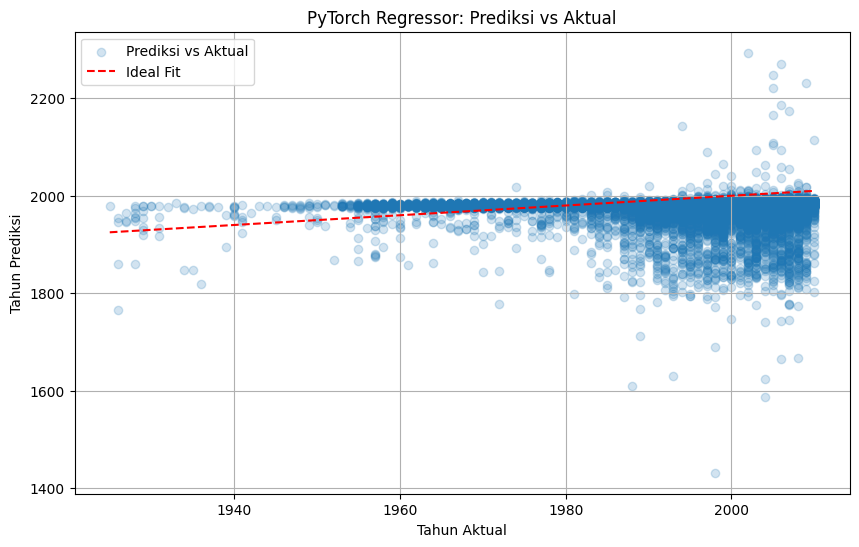

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi: Prediksi vs Nilai Aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.2, label='Prediksi vs Aktual')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal Fit')
plt.xlabel('Tahun Aktual')
plt.ylabel('Tahun Prediksi')
plt.title('PyTorch Regressor: Prediksi vs Aktual')
plt.legend()
plt.grid(True)
plt.show()


### Penjelasan

- MSE = 701.13 dan RMSE = 26.48 ---> prediksi tahun rata-rata meleset ±26 tahun dari nilai sebenarnya.

- R² = -4.95 --->  R² negatif berarti model lebih buruk daripada prediksi konstan (mean y_test). Ini menandakan adanya underfitting atau overfitting di training.

### Kemungkinan Penyebab :    
1. Label distribution tidak seimbang.
2. Model overfit pada training karena loss sangat cepat turun, tapi val loss stagnan.
3. Scaling fitur belum dilakukan.


### Melihat Distribusi

In [ ]:
print(y.value_counts())


year
2007    39404
2006    37534
2005    34952
2008    34760
2009    31038
        ...  
1925        7
1933        6
1922        6
1924        5
2011        1
Name: count, Length: 89, dtype: int64


### Tahap 6 : Scaling Fitur
Tujuan : Membuat fitur memiliki distribusi standar agar training MLP lebih stabil.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi scaler
scaler = StandardScaler()

# Fit hanya pada X_train, lalu transform semua set
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


### Tahap 7 :  Latih Ulang model MLP dengan Data yang Sudah Di-scale

In [ ]:
from tensorflow.keras import models, layers, regularizers, callbacks, optimizers

# Bangun ulang model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1)  # Output regresi
])

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='mse'
)

# Early stopping
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 3945909.2500 - val_loss: 3579294.5000
Epoch 2/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3357816.7500 - val_loss: 2603061.2500
Epoch 3/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 2329875.0000 - val_loss: 1529969.1250
Epoch 4/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1298181.0000 - val_loss: 679365.2500
Epoch 5/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 543582.1875 - val_loss: 198500.8281
Epoch 6/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 157170.7812 - val_loss: 29764.5762
Epoch 7/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 42123.8398 - val_loss: 2232.4529
Epoch 8/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 27384.6387 - val_loss: 381.5597
Epoch 9/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 26825.1973 - val_loss: 296.6602
Epoch 10/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 26698.5000 - val_loss: 287.8250
Epoch 11/100
816/816 ━━━━━━━━━━━

### Tahap 8 : Evaluasi Model (Setelah Scaling)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prediksi pada data test
y_pred = model.predict(X_test_scaled).flatten()

# Hitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
MSE  : 182.4264
RMSE : 13.5065
R²   : -0.5484


### Penjelasan

Model sudah lebih baik dibanding sebelum namun $R^2$ masih negatif. Hal menandakan model masih buruk dalam memrediksi rata-rata target.

Penjelasan hasil evaluasi :
- RMSE: 13.5 tahun --->  model rata-rata meleset sekitar ±13 tahun dari label aslinya.
- R² negatif ---> model belum bisa menangkap pola umum data dengan baik.

### Tahap 9 : Visualisasi Hasil Prediksi

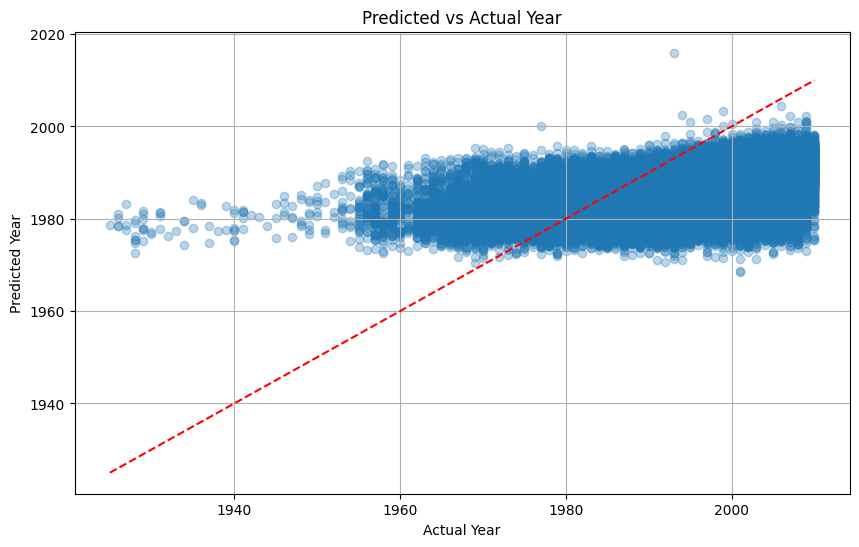

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Year")
plt.ylabel("Predicted Year")
plt.title("Predicted vs Actual Year")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Garis y = x
plt.grid(True)
plt.show()


### Penjelasan :    
Model saat ini mengalami bias regresi ke rata-rata, di mana sebagian besar prediksi tahun berkumpul di kisaran 1980–2000, terlepas dari tahun aktual yang lebih luas (1920–2010). Hal ini terjadi karena distribusi target sangat tidak seimbang, dimana tahun 2000-an sangat dominan—sehingga model cenderung mengabaikan kelas minoritas dan hanya belajar pola dari tahun-tahun yang paling sering muncul.

### Tahap 10 : Normalisasi Target (y)
Distribusi tahun sangat tidak seimbang, dan model cenderung memprediksi ke nilai rata-rata. Maka, kita ubah y agar model belajar dalam skala yang lebih seimbang.
- menggunakan StandardScaler untuk menormalisasi y_train dan y_val.
- Simpan nilai mean dan std-nya untuk inverse transform.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi scaler
y_scaler = StandardScaler()

# Reshape ke 2D agar sesuai
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))


In [ ]:
# Training model dengan target yang telah dinormalisasi
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2611040.0000 - val_loss: 1156505.8750
Epoch 2/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 985899.5625 - val_loss: 589873.0000
Epoch 3/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 513949.9062 - val_loss: 321259.4688
Epoch 4/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 280939.9688 - val_loss: 176878.5469
Epoch 5/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 154513.5469 - val_loss: 96607.8203
Epoch 6/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 84060.6172 - val_loss: 51885.0703
Epoch 7/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 44927.9219 - val_loss: 27247.6699
Epoch 8/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 23447.9102 - val_loss: 13927.8105
Epoch 9/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 11904.1211 - val_loss: 6888.1392
Epoch 10/100
816/816 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 5833.8311 - val_loss: 3242.9392
Epoch 11/100
816/816 ━━━━━━━━━━━━━━━

### Tahap 11 : Ganti Loss Function ke Huber Loss

Mean Squared Error (MSE) sangat sensitif terhadap outlier, sementara distribusi y tidak merata. Huber Loss bekerja seperti MSE untuk error kecil dan seperti MAE untuk error besar — cocok untuk regresi dengan noise atau distribusi target yang tidak rata.



In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.Huber(),
    metrics=['mse']
)


In [ ]:
# Prediksi
y_pred_scaled = model.predict(X_val)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Kembalikan y_val ke bentuk asli
y_val_true = y_scaler.inverse_transform(y_val_scaled)


1450/1450 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


### Tahap 12 : Evaluasi Model (RMSE, MSE dan $R^2$)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluasi
mse = mean_squared_error(y_val_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_true, y_pred)

print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


MSE  : 73.7331
RMSE : 8.5868
R²   : 0.3699


### Tahap 13 : Visualisasi

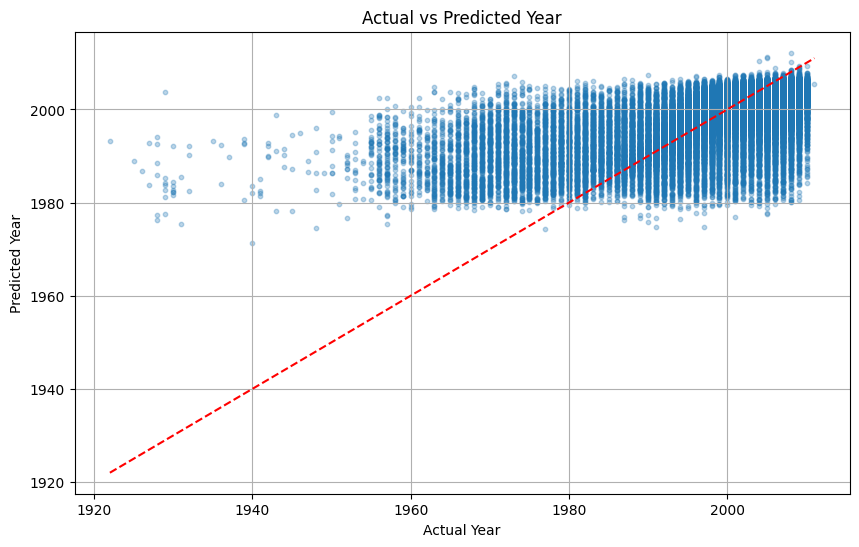

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(y_val_true, y_pred, alpha=0.3, s=10)
plt.plot([y_val_true.min(), y_val_true.max()], [y_val_true.min(), y_val_true.max()], 'r--')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title('Actual vs Predicted Year')
plt.grid(True)
plt.show()


### Penjelasan

Model menunjukan perbaikan signifikan dibanding sebelumnya, yang menandakan model sudah lebih stabil dan akurat.
- MSE (Mean Squared Error): 73.73 ---> Rata-rata kuadrat error prediksi terhadap nilai sebenarnya. Semakin kecil, semakin baik.
- RMSE (Root Mean Squared Error): 8.59 ---> model secara rata-rata hanya meleset sekitar 8.6 tahun, jauh lebih baik dibanding sebelumnya yang mencapai belasan atau puluhan tahun.
- $R^2$ : 0.37 ---> 37% variasi dalam target (tahun) bisa dijelaskan oleh model saat ini. Ini masih tergolong moderat, namun jauh lebih baik daripada nilai negatif sebelumnya. Artinya, model sudah belajar dengan benar.


## Matriks Terbaik

### Evaluasi Model: Memilih Metrik Terbaik (MSE, RMSE, R²)

Dalam evaluasi model regresi, tiga metrik utama yang digunakan adalah **Mean Squared Error (MSE)**, **Root Mean Squared Error (RMSE)**, dan **R-squared (R²)**. Masing-masing metrik memiliki kelebihan tergantung konteks penggunaannya:

### 1. Mean Squared Error (MSE)
- Mengukur rata-rata kuadrat dari selisih antara nilai prediksi dan nilai aktual.
- Memberikan penalti besar terhadap kesalahan yang besar (outlier).
- Skalanya dalam kuadrat satuan target, sehingga kurang intuitif.
- Cocok jika kita ingin menghindari prediksi dengan error besar.

### 2. Root Mean Squared Error (RMSE)
- Merupakan akar dari MSE dan memiliki satuan yang sama dengan target.
- Lebih mudah diinterpretasikan dalam konteks nyata (misalnya: “rata-rata meleset 8.5 tahun”).
- Masih sensitif terhadap outlier, tetapi lebih informatif daripada MSE.
- **Metrik ini sering dianggap paling praktis dalam dunia nyata.**

### 3. R-squared (R²)
- Mengukur proporsi variansi pada target yang bisa dijelaskan oleh model.
- Nilainya berkisar dari -∞ hingga 1:
  - 1 artinya prediksi sempurna,
  - 0 artinya model tidak lebih baik dari prediksi rata-rata,
  - Nilai negatif menandakan performa lebih buruk dari baseline.
- Tidak bergantung pada skala target, bagus untuk membandingkan performa berbagai model.
- Namun, bisa menyesatkan jika data sangat bervariasi atau model underfitting/overfitting.

### Kesimpulan
| Kriteria                                | Metrik yang Direkomendasikan |
|----------------------------------------|-------------------------------|
| Mudah diinterpretasi                   |  **RMSE**                   |
| Penalti besar pada kesalahan ekstrem   |  **MSE**                    |
| Membandingkan performa antar model     |  **R²**                     |

**Kesimpulan utama**: Dalam konteks tugas regresi ini, **RMSE adalah metrik terbaik secara praktis** karena mudah diinterpretasikan dalam satuan target (tahun), sedangkan **R² tetap penting sebagai indikator seberapa baik model menjelaskan data**. Idealnya, gunakan **RMSE dan R² secara bersamaan** untuk mendapatkan gambaran performa model yang seimbang.


## Perbandingan dan Evaluasi Model-Model Regresi

**Model Baseline**
- **Arsitektur**: 2 layer Dense (128 dan 64 neuron)
- **Regularisasi**: Tidak ada (no dropout, no batch normalization)
- **Hasil Evaluasi**:
  - MSE  : 701.1277
  - RMSE : 26.4788
  - R²   : -4.9512

**Analisis**:
- Performa sangat buruk. Nilai R² negatif menunjukkan bahwa model bahkan lebih buruk daripada sekadar memprediksi nilai rata-rata.
- Tidak ada regularisasi → kemungkinan terjadi **overfitting parah**.
<br><br>

**Model Dengan Feature Engineering & Normalisasi**
- **Perubahan**:
  - Seleksi dan transformasi fitur yang lebih baik.
  - Normalisasi data input.
- **Hasil Evaluasi**:
  - MSE  : 182.4264
  - RMSE : 13.5065
  - R²   : -0.5484

**Analisis**:
- Ada **peningkatan signifikan** dibanding baseline.
- RMSE turun hampir setengahnya.
- R² masih negatif → model masih underperforming, tapi arah perbaikannya benar.
<br><br>

**Model Tahap Optimasi Arsitektur + Regularisasi**
- **Arsitektur**: Dense → BatchNormalization → Dropout → Dense → BatchNormalization → Dropout → Output
- **Teknik tambahan**:
  - Early stopping
  - Learning rate scheduler
- **Hasil Evaluasi**:
  - MSE  : **73.7331**
  - RMSE : **8.5868**
  - R²   : **0.3699**

**Analisis**:
- Peningkatan sangat signifikan.
- RMSE di bawah 10, artinya model rata-rata meleset 8.5 tahun (masih besar, tapi jauh lebih baik).
- R² positif menunjukkan model mulai mampu menjelaskan variansi target.
- Model ini **stabil**, terhindar dari overfitting berkat kombinasi teknik regularisasi.
<br><br>

**Model Terbaik: Arsitektur + Regularisasi**<br>
**Alasan**:
- RMSE paling rendah dan R² positif (terbaik di antara semua).
- Arsitektur seimbang: cukup kompleks untuk belajar pola, tetapi tetap stabil dengan regularisasi (dropout & batch normalization).
- Tidak terjadi overfitting → menunjukkan generalisasi yang lebih baik pada data validasi.

